<a href="https://colab.research.google.com/github/ZiyuWang1121/Deep-machine-learning-meets-survival-analysis/blob/main/DeepSurv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepSurv

In this notebook we will train the [Cox-PH method](http://jmlr.org/papers/volume20/18-424/18-424.pdf), also known as [DeepSurv](https://bmcmedresmethodol.biomedcentral.com/articles/10.1186/s12874-018-0482-1).

In [1]:
!pip install torchtuples
!pip install pycox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 kB 478.8 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.2/411.2 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.9/138.9 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 56.5 MB/s eta 0:00:00
  Created wheel for feather-format: filename=feather_format-0.4.1-py3-none-any.whl size=2436 sha256=8bc1caf42374c067a035f489328e98edce61784791cd28e8cdaf4156ded3176a
  Stored in directory: /root/.cache/pip/wheels/a6/ff/5d/4f10de26fe5dde

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper

import torch
import torchtuples as tt

from pycox.models import CoxPH
from pycox.evaluation import EvalSurv

from sklearn.model_selection import ParameterSampler

In [3]:
np.random.seed(1234)
_ = torch.manual_seed(123)

## 1. Dataset

In [4]:
#pip install scikit-survival

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Read the preprocessed file
brca = pd.read_csv('/content/drive/My Drive/3799/brca.csv')

In [7]:
from sklearn.decomposition import PCA
# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.99)  # Retain 95% of the variance
x_pca = pca.fit_transform(brca.iloc[:,2:])
x_pca.shape

(1079, 956)

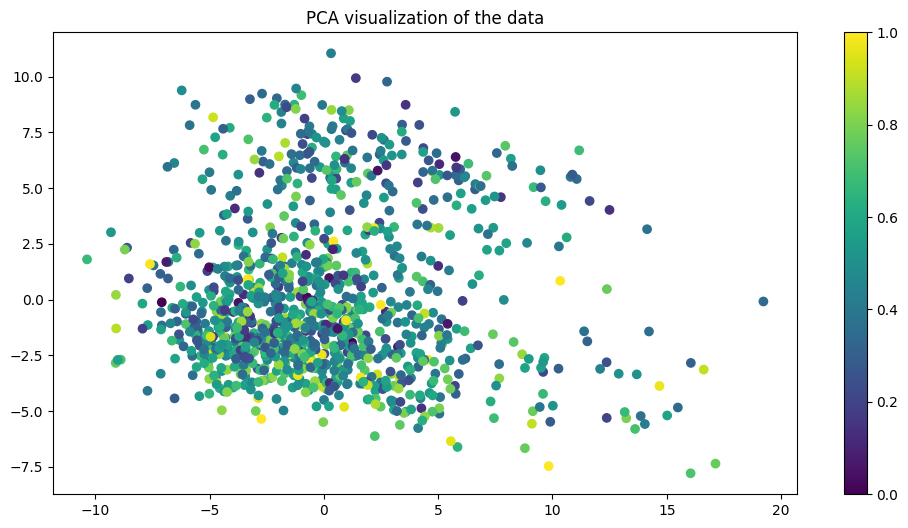

In [8]:
# Visualize dimension reduction results
plt.figure(figsize=(12, 6))
# component versus survival time
plt.scatter(x_pca[:,0], x_pca[:,1],c=brca.iloc[:,2], cmap='viridis', marker='o')
plt.colorbar()
plt.title('PCA visualization of the data')
plt.show()

In [9]:
# Concatenating the dataframes
#brca_pca = pd.concat([brca.iloc[:, :2], pd.DataFrame(x_pca)], axis=1)

###t-SNE

In [10]:
from sklearn.manifold import TSNE

# Nonlinear dimensionality reduction with t-SNE
#tsne = TSNE(n_components=3, random_state=0)
#x_tsne = tsne.fit_transform(brca.iloc[:,2:])

In [11]:
# Visualize dimension reduction results
#plt.figure(figsize=(12, 6))
# component versus survival time
#plt.scatter(x_tsne[:,0], x_tsne[:,1],c=brca.iloc[:,2], cmap='viridis', marker='o')
#plt.colorbar()
#plt.title('t-SNE visualization of the data')
#plt.show()

In [12]:
#x_tsne.shape

In [13]:
# Concatenating the dataframes
#brca_tsne = pd.concat([brca.iloc[:, :2], pd.DataFrame(x_tsne)], axis=1)

## 3. Modelling

### Train, valid, and test set split

In [14]:
data = brca

In [15]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into train, validation, and test sets while maintaining class balance
df_train_val, df_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['status'])
df_train, df_val = train_test_split(df_train_val, test_size=0.2, random_state=42, stratify=df_train_val['status'])

### Feature transforms
All variables needs to be of type `'float32'`, as this is required by pytorch.

In [16]:
from sklearn_pandas import DataFrameMapper
# Get a list of all column names in the DataFrame
all_cols = data.iloc[:,2:].columns.tolist()

# Create a list of tuples for all columns
all_cols_tuples = [(col, None) for col in all_cols]

# Create the DataFrameMapper object with all columns
x_mapper = DataFrameMapper(all_cols_tuples)

In [17]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [18]:
# Extract target
get_target = lambda df: (df['time'].values, df['status'].values)
y_train = get_target(df_train)
y_val = get_target(df_val)
y_test=get_target(df_test)
durations_test, events_test = get_target(df_test)
val = x_val, y_val

### Neural net

We create a simple MLP with two hidden layers, ReLU activations, batch norm and dropout.
Here, we just use the `torchtuples.practical.MLPVanilla` net to do this.

Note that we set `out_features` to 1, and that we have not `output_bias`.

In [19]:
from sklearn.base import BaseEstimator

class DeepSURVSklearnAdapter(BaseEstimator):
    def __init__(
        self,
        learning_rate=1e-4,
        batch_norm=True,
        dropout=0.0,
        num_nodes=[32, 32],
        batch_size=128,
        epochs=10,
    ):
        self.learning_rate = learning_rate
        self.batch_norm = batch_norm
        self.dropout = dropout
        self.num_nodes = num_nodes
        self.batch_size = batch_size
        self.epochs = epochs

    def fit(self, X, y):
        self.net_ = tt.practical.MLPVanilla(
            X.shape[1],
            self.num_nodes,
            1,
            self.batch_norm,
            self.dropout,
            output_bias = False, # prevent overfitting/simplify the model
        )
        self.deepsurv_ = CoxPH(self.net_, tt.optim.Adam)
        self.deepsurv_.optimizer.set_lr(self.learning_rate)

        # Sklearn needs the y inputs to be arranged as a matrix with each row
        # corresponding to an example but CoxPH needs a tuple with two arrays?
        y_ = (y[0], y[1])

        callbacks = [tt.callbacks.EarlyStopping()]
        log = self.deepsurv_.fit(
            X,
            y_,
            self.batch_size,
            self.epochs,
            verbose=False,
        )

        return self

    def score(self, X, y):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[0],  # time to event
            y[1],  # event
            censor_surv="km",
        )

        return ev.concordance_td()

    def brier_score(self, X, y, time_grid):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[0],  # time to event
            y[1],  # event
            censor_surv="km",
        )

        return ev.brier_score(time_grid)

    def integrated_brier_score(self, X, y, time_grid):
        _ = self.deepsurv_.compute_baseline_hazards()
        surv = self.deepsurv_.predict_surv_df(X)

        ev = EvalSurv(
            surv,
            y[0],  # time to event
            y[1],  # event
            censor_surv="km",
        )

        return ev.integrated_brier_score(time_grid)

    def predict(self, X):
        # Predict survival probabilities for X
        return self.deepsurv_.predict_surv_df(X)

In [20]:
import warnings
# Ignore FutureWarnings related to is_monotonic deprecation
warnings.filterwarnings("ignore", message="is_monotonic is deprecated")

In [21]:
# Define the parameter grid for random search
param_grid = {
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4],
    'dropout': [0.0, 0.1, 0.2],
    'num_nodes': [[32, 32], [64, 64], [32, 64]],
    'batch_size': [128, 256, 512],
    'epochs': [512]
}

# Define the number of parameter settings that will be sampled
n_iter = 10

# Perform random search
random_search = ParameterSampler(param_grid, n_iter=n_iter, random_state=123)

best_score = float('-inf')
best_params = None

for params in random_search:
    print("Current parameters:", params)
    model = DeepSURVSklearnAdapter(**params)
    model.fit(x_train, y_train)
    c_index = model.score(x_val, y_val)
    print("C-index:", round(c_index,3))
    if c_index > best_score:
        best_score = c_index
        best_params = params
    print("=" * 40)

print("Best parameters:", best_params)
print("Best C-index:", best_score)

Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.1, 'batch_size': 512}
C-index: 0.618
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.01, 'epochs': 512, 'dropout': 0.2, 'batch_size': 512}
C-index: 0.631
Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.01, 'epochs': 512, 'dropout': 0.1, 'batch_size': 512}
C-index: 0.602
Current parameters: {'num_nodes': [32, 32], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.0, 'batch_size': 256}
C-index: 0.582
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.2, 'batch_size': 256}
C-index: 0.617
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.2, 'batch_size': 128}
C-index: 0.615
Current parameters: {'num_nodes': [64, 64], 'learning_rate': 0.1, 'epochs': 512, 'dropout': 0.1, 'batch_size': 128}
C-index: 0.619
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.001, 'epochs':

/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:231: RuntimeWarning: overflow encountered in exp
  .assign(expg=np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)))
/usr/local/lib/python3.10/dist-packages/pycox/models/cox.py:251: RuntimeWarning: overflow encountered in exp
  expg = np.exp(self.predict(input, batch_size, True, eval_, num_workers=num_workers)).reshape(1, -1)


C-index: 0.0
Current parameters: {'num_nodes': [32, 64], 'learning_rate': 0.001, 'epochs': 512, 'dropout': 0.0, 'batch_size': 128}
C-index: 0.58
Best parameters: {'num_nodes': [64, 64], 'learning_rate': 0.01, 'epochs': 512, 'dropout': 0.2, 'batch_size': 512}
Best C-index: 0.6308002689979825


## Evaluation and Prediction

In [22]:
# Initialize lists to store C-index and integrated Brier score
c_index_scores = []
integrated_brier_scores = []

# Repeat the process 20 times
for _ in range(20):
    # Create and train the best model with the best parameters
    best_model = DeepSURVSklearnAdapter(**best_params)
    best_model.fit(x_train, y_train)

    # Evaluate the best model on the test data
    c_index = best_model.score(x_test, y_test)
    c_index_scores.append(c_index)

    # Calculate integrated Brier score
    time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
    integrated_brier = best_model.integrated_brier_score(x_test, y_test, time_grid)
    integrated_brier_scores.append(integrated_brier)

In [23]:
# Calculate the mean C-index and integrated Brier score
mean_c_index = np.mean(c_index_scores)
mean_integrated_brier = np.mean(integrated_brier_scores)

print("Mean C-index:", round(mean_c_index, 3))
print("Mean integrated Brier score:", round(mean_integrated_brier, 3))

Mean C-index: 0.721
Mean integrated Brier score: 0.195


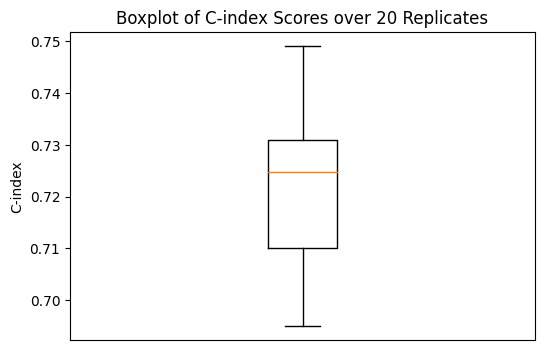

In [24]:
# Plot boxplot of C-index scores over 20 replicates
plt.figure(figsize=(6, 4))
plt.boxplot(c_index_scores)
plt.title('Boxplot of C-index Scores over 20 Replicates')
plt.ylabel('C-index')
plt.xticks([])
plt.show()

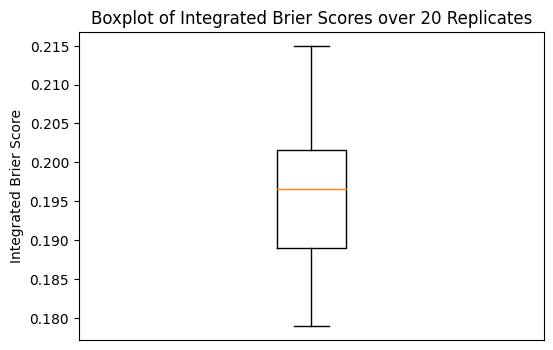

In [25]:
# Plot boxplot of integrated Brier scores
plt.figure(figsize=(6, 4))
plt.boxplot(integrated_brier_scores)
plt.title('Boxplot of Integrated Brier Scores over 20 Replicates')
plt.ylabel('Integrated Brier Score')
plt.xticks([])
plt.show()